# Pump It Up Challenge - Understanding

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime as dt
from scripts import pumpitup

from scipy import stats

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold

sns.set_style("white")
sns.set_context("talk")

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.options.display.max_columns = 50

# Training Data

## Data

In [5]:
train_data = pd.read_csv('data/training_set.csv')

In [173]:
df = pd.read_csv('data/training_set.csv')

## Labels

In [6]:
train_labels = pd.read_csv('data/training_labels.csv')

## Cleaning

In [7]:
train_data = pumpitup.cleanitup(train_data)

/Users/George/projects/unv/pumpit/scripts/pumpitup.py:463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wpt_name'][df['wpt_name'].str.contains('school')] = 'school'
/Users/George/projects/unv/pumpit/scripts/pumpitup.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wpt_name'][df['wpt_name'].str.contains('shule')] = 'school'
/Users/George/projects/unv/pumpit/scripts/pumpitup.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wpt_name'][df['wpt_name'].str.contains('se

In [8]:
modifiers = train_data[1]
train_data = train_data[0]

# Understanding the Data

## Geographical

Let's have a look at the geographical distribution of pump status.

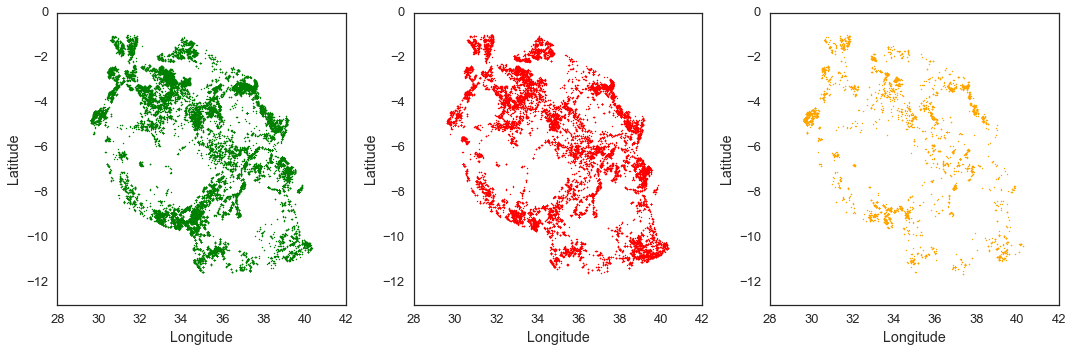

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(train_data['longitude'][train_labels['status_group'] == 'functional'],\
           train_data['latitude'][train_labels['status_group'] == 'functional'], color='green', s=2, linewidth=0)
ax[1].scatter(train_data['longitude'][train_labels['status_group'] == 'non functional'],\
           train_data['latitude'][train_labels['status_group'] == 'non functional'], color='red', s=2, linewidth=0)
ax[2].scatter(train_data['longitude'][train_labels['status_group'] == 'functional needs repair'],\
           train_data['latitude'][train_labels['status_group'] == 'functional needs repair'], color='orange', s=2, linewidth=0)

ax[0].set_ylim(-13, 0)
ax[0].set_xlim(28, 42)
ax[0].set_ylabel('Latitude')
ax[0].set_xlabel('Longitude')
ax[1].set_ylim(-13, 0)
ax[1].set_xlim(28, 42)
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
ax[2].set_ylim(-13, 0)
ax[2].set_xlim(28, 42)
ax[2].set_ylabel('Latitude')
ax[2].set_xlabel('Longitude')

plt.tight_layout()

The different classes seem to be distributed similarly across the country, though it's hard to say with any certainty or to see whether there are clusters.

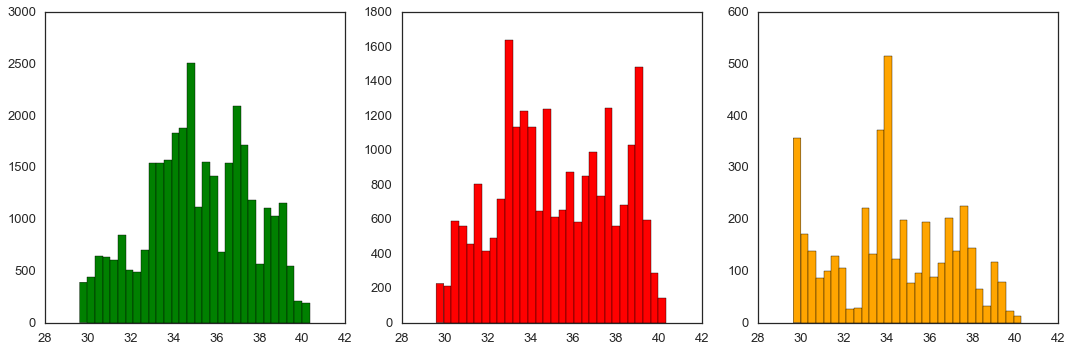

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(train_data['longitude'][train_labels['status_group'] == 'functional'], bins=30, color='green')
ax[1].hist(train_data['longitude'][train_labels['status_group'] == 'non functional'], bins=30, color='red')
ax[2].hist(train_data['longitude'][train_labels['status_group'] == 'functional needs repair'], bins=30, color='orange')

plt.tight_layout()

In [196]:
longitude_steps = np.histogram(train_data['longitude'], bins=39)[1]

In [197]:
latitude_steps = np.histogram(train_data['latitude'], bins=39)[1]

In [198]:
latitude_step = (train_data['latitude'].max() - train_data['latitude'].min()) / 40

In [199]:
longitude_step = (train_data['longitude'].max() - train_data['longitude'].min()) / 40

In [201]:
grid_func = np.zeros((20, 20))
grid_nonfunc = np.zeros((20, 20))
grid_repair = np.zeros((20, 20))
grid = np.zeros((3, 40, 40))

functional = train_data[train_labels['status_group'] == 'functional']
non_functional = train_data[train_labels['status_group'] == 'non functional']
repair = train_data[train_labels['status_group'] == 'functional needs repair']

status_group = train_labels['status_group']

for i, lat in enumerate(latitude_steps):
    lat_mask = (train_data['latitude'] >= lat) & (train_data['latitude'] < lat + latitude_step)
    
    for j, lon in enumerate(longitude_steps):        
        lon_mask = (train_data['longitude'] >= lon) & (train_data['longitude'] < lon + longitude_step)

        num_pumps = len(train_data[lat_mask & lon_mask])

        if num_pumps == 0:
            continue
        else:
            grid[0, i, j] = len(status_group[(status_group == 'functional')\
                                               & lat_mask & lon_mask]) / num_pumps
            grid[1, i, j] = len(status_group[(status_group == 'non functional')\
                                                  & lat_mask & lon_mask]) / num_pumps
            grid[2, i, j] = len(status_group[(status_group == 'functional needs repair')\
                                                 & lat_mask & lon_mask]) / num_pumps

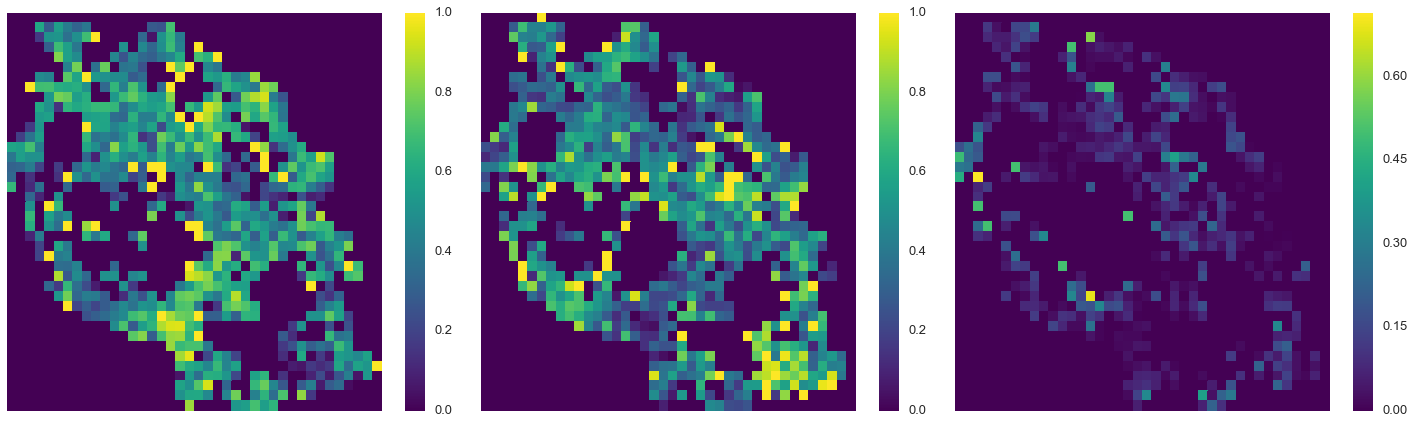

In [202]:
fig, axes = plt.subplots(1,3, figsize=(20, 6))

for i, ax in enumerate(axes):
    sns.heatmap(grid[i], ax=ax, cmap='viridis', annot=True, xticklabels=False, yticklabels=False)
    ax.invert_yaxis()

plt.tight_layout()

In [175]:
viridis = plt.cm.get_cmap('viridis')

In [73]:
functionals = train_labels[(lat_mask) & (lon_mask)]

In [80]:
le = preprocessing.LabelEncoder

In [83]:
labels_num = le.fit_transform(train_labels['status_group'])

TypeError: fit_transform() missing 1 required positional argument: 'y'

# Extra Features

Wait one second, before we go any further, there's a few extra features that we can engineer from this dataset.

### Nearest Neigbouring Pump

**Taking too long to calculate (optimise?)**

One factor that might affect whether a pump is used is the distance from another pump.

In [44]:
lons = train_data['longitude'].as_matrix()
lats = train_data['latitude'].as_matrix()

In [15]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [53]:
haversine(train_data['longitude'][0], train_data['latitude'][0], train_data['longitude'][1], train_data['latitude'][1])

857.59352828516387

In [30]:
min_dist = []

for i in range(0, len(train_data)):
    lats_temp = lats.copy()
    lons_temp = lons.copy()
    
    lat1 = lats_temp.pop(i)
    lon1 = lons_temp.pop(i)
    
    haversine_dist = [haversine(lon1, lat1, lon2, lat2) for lon2, lat2 in zip(lons_temp, lats_temp)]
    
    min_dist.append(min(haversine_dist))
    

KeyboardInterrupt: 

In [20]:
longs = train_data['longitude']

In [35]:
from scipy.spatial import distance

In [40]:
coords = list(zip(lons, lats))

In [ ]:
arr = np.abs(lats[:, None] - lats)

In [48]:
lats[:, None]

array([[-9.85632177],
       [-2.14746569],
       [-3.82132853],
       ..., 
       [-8.75043433],
       [-6.37857327],
       [-6.74746425]])

In [91]:
a = enumerate(zip([1,2,3], [4,5,6]))
a

In [93]:
for i, (b) in a:
    b, c = b
    print(i, b, c)

1 2 5
2 3 6


In [126]:
a = np.arange(6)

In [129]:
b = a[::-1]

In [130]:
b

array([5, 4, 3, 2, 1, 0])

In [165]:
x = np.zeros((3, 4, 4))

In [167]:
x[1,2,3]

0.0